<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---

## **Day06 Morning Session: Autoencoders and Variational Autoencoders**

# Introduction

In this session you will implement two simple generative models. The first will be an Autoencoder, and the second a Variational Autoencoder, both will generate handwritten digits from MNIST.

The code is based on a resource by Alexander Van de Kleut https://avandekleut.github.io/vae/ who introduces Autoencoders and then Variational Autoencoders (VAE's).


# 0 Preliminaries

## 0.1 Mount Google-drive

We start by mounting Google-drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Import libraries

We will need the following libraries


In [1]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy

device = 'cuda'  # Set out device to GPU

print('done')  # Let me know this cell has finished

done


## 0.3 Load MNIST

We load the MNIST data-set


In [ ]:
# MNIST Test dataset and dataloader declaration
batch_size = 128
data = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),])
                   ),
                   batch_size=batch_size, shuffle=True) # Load MNIST. Use the Data Loader to shuffle and batch images

images, labels = next(iter(data)) # A trick for getting a batch out of the dataloader object
plt.imshow(images[0].squeeze()) # Show the first image from the batch
plt.show()

print('number of batches = '+str(len(data))) # Print num batches
print('number of images = '+str(len(data)*batch_size)) # Print num images


# 1 The Autoencoder

This tutorial will teach you to build an **Autoencoder** which is capable of generating handwritten digits after training on the MNIST dataset.

This week you have seen that Generative Models capture the joint probability distribution of an observed and a latent variable. An Autoencoder is a "Deep Generative Model" where an observed variable is transformed to a latent space using an "Enconder" neural network, and the latent space is transformed back to the observed variable space using a "Decoder" neural network. The following diagram shows this visually


## 1.1 Architecture

![AE_Diagram_nNotation.jpg](https://avandekleut.github.io/assets/vae/autoencoder.png)

## 1.2 Encoder

Auto-encoders use an encoder-decoder framework, where the encoder and decoder are neural networks. We will build an Autoencoder where the Encoder network and the Decoder network have 2 fully-connected layers.

The architecture of the Encoder is as follows:

1. The input layer: 784 nodes (becuase the MNIST images are 28x28 pixels)
2. The first layer: 512 nodes
3. The second: 256 nodes

Use ReLU for your activation function.

The outline of the encoder module is below, complete the following exercises

---

*To learn more about PyTorch neural network modules* https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

In [7]:
class Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(Encoder, self).__init__()
    # The input layer: 784 nodes (becuase the MNIST images are 28x28 pixels)
    # The first layer: 512 nodes The second: 256 nodes
    dimensions = [784,512,256]
    self.layer0 = nn.Linear(dimensions[0], dimensions[1])  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 =  nn.Linear(dimensions[1], dimensions[-1]) # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = x.flatten(start_dim=1)  # Reshape the input into a vector (nD to 1D)
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x

  print('done') # Show when the module has run

done


## 1.3 Decoder

The decoder will have the same architecture as the decoder but in reverse. Therefore

2. The first layer: 256 nodes
3. The second layer: 512 nodes
4. The output layer will have 784 nodes.

Again, use ReLU activations, apart from the output layer which will use a Sigmoid acitvations (because MNIST images pixel valeus are between 0 and 1).

In [12]:
class Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(Decoder, self).__init__()
    dimensions = [784,512,256]

    # self.layer0 = nn.Linear(dimensions[0], dimensions[1])  # Image to hidden, fully connected
    # self.transform0 = nn.ReLU()
    # self.layer1 =  nn.Linear(dimensions[1], dimensions[-1]) # Image to hidden, fully connected
    # self.transform1 = nn.ReLU()

    self.layer1 = nn.Linear(dimensions[-1], dimensions[1])  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut =  nn.Linear(dimensions[1], dimensions[0]) # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):
    '''
    z: [float] a sample from the latent variable
    '''

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape(-1, 1, 28, 28) # Reshape the vector into an image

print('done')

done


## 1.4 Autoencoder

The Autoencoder structure inherits from the Encoder and the Decoder. This is done by "dependency injection" (where the Enconder and Decoder class are assigned to properties of the Autoencoder). The forward module of the Autoencoder should take and image, run the Encoder (image -> latent) then run the Decoder to make a prediction (latent -> generated image).

The Autoencoder is below, and the latent space will have variable dimensionality.



In [14]:
class Autoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder with an Autoencoder latent space.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''

    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

    self.latentIn = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.Sigmoid()

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

    x = self.encoder(x)  # Run the image through the Encoder
    z = self.latentIn(x)  # Take the output of the encoder and get the latent vector
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z)  # Return the output of the decoder (the predicted image)

print('done')

done


## 1.5 Training

We train the Autoencoder by stocastic gradient descent, you have seen this process several times in different forms. My implementation of this process is below:

In [16]:
def train(autoencoder, data, kl_div_on=True, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    criterion = nn.MSELoss()
    autoencoder.to(device)
    for epoch in range(epochs):  # Run data over numerous epochs
        for X, y in data:  # Iterate over the batches of images and labels
            X = X.to(device) # Send batch of images to the GPU
            y = y.to(device) # Send batch of images to the GPU

            # Set optimiser grad to 0
            opt.zero_grad()
            x_hat =  autoencoder(X)# Generate predicted images (x_hat) by running batch of images through autoencoder
            # loss = criterion(x_hat, y)  # Calculate L2 loss
            loss = ((X - x_hat)**2).sum()
            # Back-propagate
            loss.backward()
            # Step the optimiser
            opt.step() # ???
    return autoencoder  # Return the trained autoencoder (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
autoencoder = Autoencoder(dims_latent)
autoencoder = train(autoencoder, data, 10)

print('done')

done


In [17]:

:

SyntaxError: ignored

## 1.6 Latent space visualisation

Have a look at the latent space before and after training.


In [19]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n, (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z = autoencoder.latentIn(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detatch().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
            plt.colorbar()
            break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z = autoencoder.latentIn(autoencoder.encoder(image.to(device))) # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy() # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(autoencoder, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(autoencoder, data)
plot_2D_latent_sample(autoencoder, image)

AttributeError: ignored

## 1.7 Generate new images

We need to see what our generative model can do! Lets take some random samples from the latent space and see what our model produces.

In [ ]:
def plot_sample(autoencoder, z):
    img = # turn z into image data
    plt.imshow(img)
    plt.show()
    print(z)

z = torch.tensor([-10, 5]).to(device).float()
plot_sample(autoencoder, z)

## 1.8 Generate interpolation grids

Looking at random samples is all very well, what we really want to see is whether the labels in the latent space acutally generate what we expect. Plot a grid showing the outputs of different parts of the latent space.

In [ ]:
def plot_grid(autoencoder, n=(10, 10), param_range=(-3, 3)):
  x_range = torch.linspace(param_range[0], param_range[1], n[0])
  y_range = torch.linspace(param_range[0], param_range[1], n[1])
  grid_y, grid_x = torch.meshgrid(x_range, y_range)

  z = torch.zeros(2,n[0]*n[1])
  z[1] = grid_x.reshape(n[0]*n[1],1).squeeze()
  z[0] = grid_y.reshape(1,n[0]*n[1]).permute(1,0).flip(1).squeeze()
  z = z.to(device)

  fig, axarr = plt.subplots(n[0], n[1], figsize=(10, 10))
  im_s = np.zeros((n[0]*n[1], 28**2))
  for n in range(0,n[0]*n[1]):
    decoder_input = autoencoder.activationOut(autoencoder.latentOut(z[:,n]))
    im_s[-n-1,:] = autoencoder.decoder(decoder_input).flatten().to('cpu').detach().numpy()

  for ax, img in zip(axarr.flatten(), im_s):
    ax.imshow(img.reshape(28,28), cmap="gray")

plot_grid(autoencoder, param_range=(-50, 50))

# 2 The Variational Autoencoder

This tutorial will teach you to build a **Variational Autoencoder** (VAE) which is capable of generating handwritten digits after training on the MNIST dataset.

In the Theory session you learnt that VAE's and Autoencoders are identical in structure apart from in their latent space, which we force to be a distribution of our choosing. The following diagram shows the VAE which also uses the reparameterisation trick, which is the most common approach to enable VAE training. An alternative approach **does not** use the reparameterisation trick and the set-up will be identical to the autoencoder above, but in this case the gradient of the loss-function should use the log-derivative trick.

## 2.1 Architecture

![VAE_Diagram.jpg](https://avandekleut.github.io/assets/vae/variational-autoencoder.png)

## 2.2 Encoder

The set-up of the Encoder will be identical to the Autoencoder architecture


In [20]:
class VAE_Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(VAE_Encoder, self).__init__()
    self.layer0 = nn.Linear(784, 512)  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)  # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D)
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x


## 2.3 Decoder

The set-up of the Encoder will be identical to the Autoencoder architecture


In [21]:
class VAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()
    self.layer1 = nn.Linear(256, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 784)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):
    '''
    z: [float] a sample from the latent variable
    '''

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,28,28))  # Reshape the vector into an image

print('done')

done


## 2.4 Variational Autoencoder

The VAE structure also inherits from the Encoder and the Decoder. The forward module of the VAE should take and image, run the encoder (image -> latent) then run the decoder to make a prediction (latent -> generated image).

The VAE is below, and the latent space will have variable dimensionality. We will use the Reparameterisation trick in our VAE.

The loss functions of VAE:
* latent space KL divergence: $\mathbb{KL}\left( \mathcal{N}(\mu, \sigma^2 \mathbf{\mathit I}) \parallel \mathcal{N}(\mathit 0, \mathbf{\mathit I}) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$
* $L_2$ for generation loss

In [27]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''

    super(VariationalAutoencoder, self).__init__()
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()

    # red
    self.layerMu = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    # green
    self.layerSig = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    # purple
    self.distribution = torch.distributions.Normal(0,1)  # Sample epsilon from N(0,1)

    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()


  def vae_latent_space(self, x):
    mu = self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x)) # Exponential activation ensures positivity for Sigma
    z = mu * sigma * self.distribution.sample(mu.shape).to(device) # z = mu + sigma * epsilon
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() # latent space loss -- KL_divergence
    return z, kl_div

  def forward(self, x):
    x = self.encoder(x)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z), kl_div

print('done')

done


## 2.5 Training

Once we have a VAE which contains the re-parameterised latent space, we can train as previous.

In [39]:
def train(vae, data, kl_div_on=True, epochs=10):
  opt = torch.optim.Adam(vae.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      label = label.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = vae(batch) # Generate predicted images (x_hat) by running batch of images through autoencoder; also generates KL div
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss (L2 + KL)
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return vae  # Return the trained vae (for later analysis)


dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
# VAE = VariationalAutoencoder(dims_latent).to(device)
VAE = train(VAE, data, 1)

print('done')

done


## 2.6 Latent space visualisation

Have a look at the latent space before and after training (a one tweak is needed).



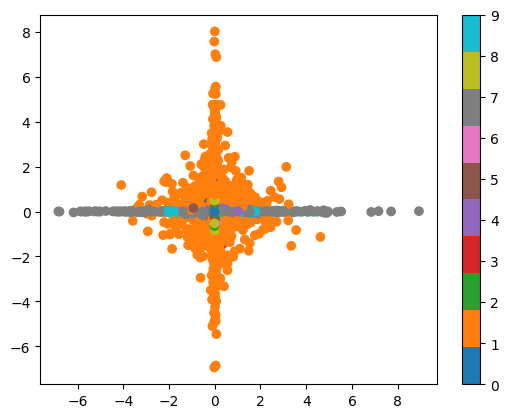

tensor([5, 7, 8, 8, 4, 4, 7, 7, 8, 8, 0, 8, 1, 7, 3, 6, 8, 3, 5, 3, 3, 8, 6, 0,
        3, 2, 9, 3, 6, 4, 9, 2, 8, 2, 0, 8, 2, 2, 9, 5, 7, 4, 3, 9, 9, 1, 4, 5,
        3, 5, 9, 6, 4, 7, 5, 9, 6, 1, 2, 4, 6, 1, 6, 2, 5, 4, 4, 4, 6, 0, 1, 7,
        2, 7, 8, 7, 2, 3, 8, 3, 3, 8, 2, 1, 7, 2, 5, 1, 6, 7, 0, 0, 6, 3, 7, 8,
        2, 4, 8, 5, 8, 0, 5, 6, 7, 7, 7, 7, 3, 7, 4, 0, 4, 1, 2, 1, 9, 6, 6, 3,
        5, 4, 5, 9, 6, 7, 3, 8])
tensor(5)


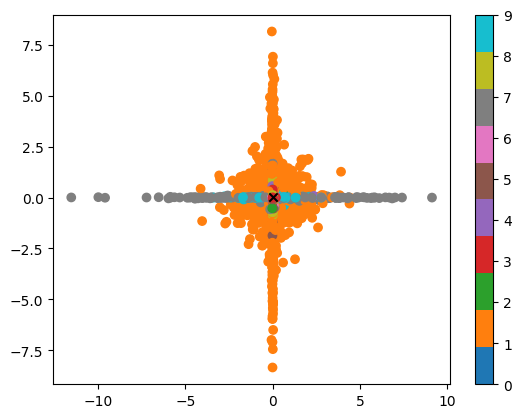

In [29]:
def plot_2D_latent_space(autoencoder, data, num_batches=100):
    '''
    Plot a the latent vector for a lots of images
    '''
    for n , (x, y) in enumerate(data):  # enumerate means n = n + 1 per iteration. x is the batch of images, y are the class labels
        z, KL = autoencoder.vae_latent_space(autoencoder.encoder(x.to(device)))  # Run the batch through the Encoder and Latent input layer
        z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')  # Scatter plot of latent vector colourised by the class label y
        if n > num_batches:  # stop after n > maximum number of batches
          plt.colorbar()
          break

def plot_2D_latent_sample(autoencoder, image):
    '''
    Plot a the latent vector for a single image
    '''
    z, KL = autoencoder.vae_latent_space(autoencoder.encoder(image.to(device)))  # Run the image through the Encoder and Latent input layer
    z = z.to('cpu').detach().numpy()  # Send latent vector to cpu
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Scatter plot of latent vector

plot_2D_latent_space(VAE, data)
plt.show()

x,y = next(iter(data)) # Get next iteration from data iterator
print(y)

n = 0  # Choose a label
print(y[n]) # Print out chose label

image = x[n]
plt.figure()
plot_2D_latent_space(VAE, data)
plot_2D_latent_sample(VAE, image)

## 2.7 Generate new images

Now we can generate new images BUT we can also determine the likelihood of a given image by sampling from the standard normal distribution $z_i \sim \mathcal{N}(0, \mathbf{I})$!

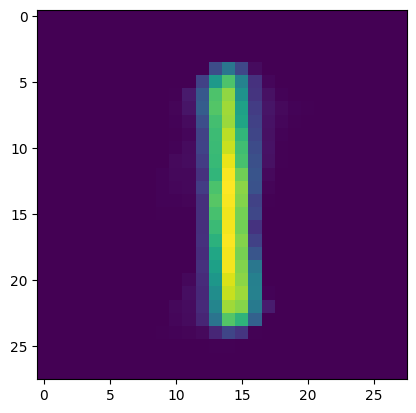

tensor([1.1701, 0.6002], device='cuda:0')


<Figure size 640x480 with 0 Axes>

In [30]:
def plot_sample(autoencoder, z):
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach().numpy()[0,0]
    plt.imshow(img)
    plt.show()
    plt.savefig("./generated_image.jpg")  # Save the figure to google drive!
    print(z)

z = torch.randn(2).to(device).float()
plot_sample(VAE, z)

tensor([1.0736, 0.5982], device='cuda:0')
tensor([4., 0.], device='cuda:0')


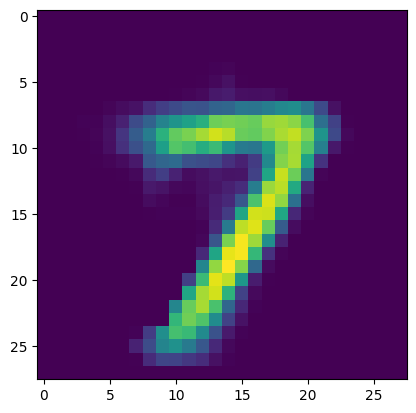

tensor([4., 0.], device='cuda:0')


<Figure size 640x480 with 0 Axes>

In [38]:
z = torch.randn(2).to(device).float()
print(z)
z = torch.tensor([4,0]).to(device).float()
print(z)

plot_sample(VAE, z)

# 3 Other learning resources

https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

https://arxiv.org/abs/1606.05908



# 4 Resources worth reading

**Loss functions for computer vision**
https://medium.com/ml-cheat-sheet/winning-at-loss-functions-2-important-loss-functions-in-computer-vision-b2b9d293e15a

**Conditional Variational Autoencoders** These are mentioned in the Theory presentation https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/ (Note, I think the code uses tensorflow)

**Normalising flows** are similar to VAE's but each layer has the same dimensionality as the input and uses the change of variables equation https://arxiv.org/pdf/1606.04934.pdf

**Modern architectures**

Autoregressive models (PixelCNN) https://bjlkeng.github.io/posts/pixelcnn/

Nouveau VAE https://arxiv.org/abs/2007.03898

Very deep VAE's  https://arxiv.org/pdf/2011.10650.pdf

